# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [976]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False).transpose()
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False).transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia,...,Gambia,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,South Sudan,Sao Tome and Principe,Yemen
2020-04-20,784326,200210,181228,156480,147065,125856,90980,83505,83817,47121,...,10,9,9,7,7,6,5,4,4,1
2020-04-21,812036,204178,183957,159297,148291,130172,95591,84802,83853,52763,...,10,9,9,7,7,6,6,4,4,1
2020-04-22,839675,208389,187327,157125,150648,134638,98674,85996,83868,57999,...,10,9,9,8,7,6,6,4,4,1


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Fiji,Chad,Bhutan,Central African Republic,Maldives,Seychelles,Mongolia,Eritrea,South Sudan,Sierra Leone
2020-04-20,42094,24114,20852,20292,16550,5828,5209,4862,4636,3764,...,0,0,0,0,0,0,0,0,0,0
2020-04-21,44444,24648,21282,20829,17378,5998,5297,5033,4636,3929,...,0,0,0,0,0,0,0,0,0,0
2020-04-22,46583,25085,21717,21373,18151,6262,5391,5279,4636,4068,...,0,0,0,0,0,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [977]:
df_rolls = dfc_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(columns={df_rolls.columns[0]:'Cases3dayAvg'})
df_rolls['Cases7dayAvg'] = dfc_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Cases14dayAvg'] = dfc_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls['Deaths3dayAvg'] = dfd_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls['Deaths7dayAvg'] = dfd_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Deaths14dayAvg'] = dfd_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(index={'US':'United States'})
df_rolls.head()


,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,
United States,26955.333333,29046.428571,29358.642857,1974.000000,2606.428571,2277.071429
Spain,3238.333333,4392.142857,4297.785714,421.333333,429.857143,494.642857
Italy,2785.000000,3167.428571,3421.785714,475.000000,491.428571,529.714286
France,1009.333333,3220.428571,5290.571429,543.000000,597.857143,749.000000
Germany,1821.333333,2270.714286,2668.000000,231.000000,210.714286,209.285714


## Add Global Population by Country

In [978]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'RUS','Country Name'] = 'Russia'
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})
display(df_gpop_2016[df_gpop_2016['Country/Region'].isin(['Italy','Russian Federation','Russia'])])

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })

# merge rolling averages
df_gmerged = pd.merge(left=df_gmerged, right=df_rolls, on='Country/Region')

display(df_gmerged.sort_values(by=['Population'], ascending=False).head(10))  
display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


,Country/Region,Country Code,Year,Value
8427,Italy,ITA,2016,60627498
12259,Russia,RUS,2016,144342396


,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
7,China,4636,83868,CHN,2016,1378665000,21.000000,73.142857,75.642857,0.000000,184.285714,92.785714
17,India,681,21370,IND,2016,1324509589,1251.666667,1292.571429,1103.857143,40.666667,39.428571,35.928571
0,United States,46583,839675,USA,2016,322941311,26955.333333,29046.428571,29358.642857,1974.000000,2606.428571,2277.071429
18,Indonesia,635,7418,IDN,2016,261554226,281.000000,326.000000,318.714286,17.666667,23.714286,28.214286
9,Brazil,2906,45757,BRA,2016,206163058,2367.666667,2491.000000,2113.357143,148.000000,167.142857,149.071429
31,Pakistan,212,10076,PAK,2016,203627284,576.000000,527.571429,415.214286,14.666667,14.428571,10.785714
70,Nigeria,28,873,NGA,2016,185960289,82.000000,66.571429,42.642857,2.333333,2.285714,1.571429
43,Bangladesh,120,3772,BGD,2016,157970840,438.666667,363.000000,253.857143,9.666667,10.000000,7.142857
22,Russia,513,57999,RUS,2016,144342396,5048.666667,4787.000000,3523.357143,50.666667,45.000000,32.142857
28,Japan,281,11512,JPN,2016,126994511,238.333333,487.428571,518.214286,15.000000,19.285714,13.428571


2020-01-22    185
dtype: int64

160

## Add Various Other Data from WorldBank.Org

In [979]:
# all available indicators https://data.worldbank.org/indicator
#    API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#    I should bundle into a single request XLS or Json results, but alas.. this works for now
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def get_zip(url):
    urllib.request.urlretrieve(url, "X.zip")
    compressed_file = zipfile.ZipFile('X.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [980]:
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False) # 0 data for g10's
#df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('IS.SHP.GOOD.TU', 'shipping', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.LE00.IN', 'lifeExpYrs', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FP.CPI.TOTL.ZG', 'inflation', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.TFRT.IN', 'fertility', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)

df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])
df_gmerged3.head()

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,46583,839675,USA,322941311,26955.333333,29046.428571,29358.642857,1974.000000,2606.428571,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
2,Spain,21717,208389,ESP,46484062,3238.333333,4392.142857,4297.785714,421.333333,429.857143,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67
1,Italy,25085,187327,ITA,60627498,2785.000000,3167.428571,3421.785714,475.000000,491.428571,...,205.45,41830.43,10547112.0,82.95,0.61,1.32,4.9,95.0,22.75,50.26
3,France,21373,157125,FRA,66721256,1009.333333,3220.428571,5290.571429,543.000000,597.857143,...,122.34,45342.40,6369200.0,82.53,1.11,1.90,6.0,96.0,20.03,45.16
6,Germany,5279,150648,DEU,82348669,1821.333333,2270.714286,2668.000000,231.000000,210.714286,...,237.37,53074.54,19597633.0,80.99,1.45,1.56,4.8,93.0,21.46,72.11


In [981]:
df_gmerged3.head(10).transpose()

,0,2,1,3,6,4,10,7,22,9
Country/Region,United States,Spain,Italy,France,Germany,United Kingdom,Turkey,China,Russia,Brazil
Deaths,46583,21717,25085,21373,5279,18151,2376,4636,513,2906
Cases,839675,208389,187327,157125,150648,134638,98674,83868,57999,45757
Country Code,USA,ESP,ITA,FRA,DEU,GBR,TUR,CHN,RUS,BRA
Population,322941311,46484062,60627498,66721256,82348669,65611593,79821724,1378665000,144342396,206163058
Cases3dayAvg,26955.3,3238.33,2785,1009.33,1821.33,4488.67,4122.67,21,5048.67,2367.67
Cases7dayAvg,29046.4,4392.14,3167.43,3220.43,2270.71,5022.14,4183.14,73.1429,4787,2491
Cases14dayAvg,29358.6,4297.79,3421.79,5290.57,2668,5226,4317.71,75.6429,3523.36,2113.36
Deaths3dayAvg,1974,421.333,475,543,231,685.333,119.667,0,50.6667,148
Deaths7dayAvg,2606.43,429.857,491.429,597.857,210.714,751,122.571,184.286,45,167.143


# Correlation Matrix

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.924823,0.177840,0.820704,0.855122,0.877425,0.950804,0.931579,0.957911,0.729634,...,-0.025788,0.249829,0.276573,0.174786,-0.042569,-0.164357,-0.159116,0.089425,0.304146,-0.077843
Cases,0.924823,1.000000,0.223744,0.958375,0.973821,0.981380,0.971866,0.979358,0.968091,0.881424,...,-0.023868,0.246757,0.320966,0.148970,-0.033330,-0.151463,-0.151368,0.084181,0.247467,-0.091531
Population,0.177840,0.223744,1.000000,0.187462,0.186829,0.179254,0.153322,0.197700,0.172368,0.505306,...,-0.018107,-0.041483,0.737270,0.022742,0.003678,-0.052492,-0.021255,0.032079,0.014386,-0.143120
Cases3dayAvg,0.820704,0.958375,0.187462,1.000000,0.996436,0.986953,0.933235,0.948687,0.919537,0.877488,...,-0.012322,0.224427,0.236301,0.116642,-0.023129,-0.131925,-0.129680,0.072663,0.180116,-0.087469
Cases7dayAvg,0.855122,0.973821,0.186829,0.996436,1.000000,0.996479,0.954118,0.966099,0.944039,0.877883,...,-0.016786,0.228507,0.238658,0.123763,-0.025229,-0.135159,-0.133760,0.074142,0.197064,-0.093168
Cases14dayAvg,0.877425,0.981380,0.179254,0.986953,0.996479,1.000000,0.967906,0.977786,0.961474,0.873720,...,-0.020043,0.231472,0.237013,0.128835,-0.026235,-0.134429,-0.135783,0.075408,0.207524,-0.093197
Deaths3dayAvg,0.950804,0.971866,0.153322,0.933235,0.954118,0.967906,1.000000,0.993405,0.996651,0.824139,...,-0.025805,0.249638,0.226519,0.152906,-0.035873,-0.145861,-0.145074,0.078210,0.262326,-0.084089
Deaths7dayAvg,0.931579,0.979358,0.197700,0.948687,0.966099,0.977786,0.993405,1.000000,0.993546,0.869832,...,-0.024178,0.231622,0.287984,0.137399,-0.033080,-0.133741,-0.134796,0.074492,0.233986,-0.086638
Deaths14dayAvg,0.957911,0.968091,0.172368,0.919537,0.944039,0.961474,0.996651,0.993546,1.000000,0.825857,...,-0.024504,0.241906,0.256820,0.149436,-0.035961,-0.141521,-0.141766,0.078808,0.256553,-0.080860
flights,0.729634,0.881424,0.505306,0.877488,0.877883,0.873720,0.824139,0.869832,0.825857,1.000000,...,-0.025707,0.223638,0.616151,0.137966,-0.034364,-0.157551,-0.150103,0.092211,0.185224,-0.103879


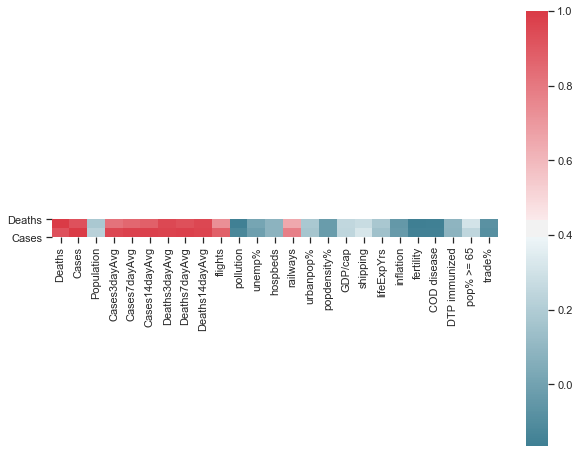

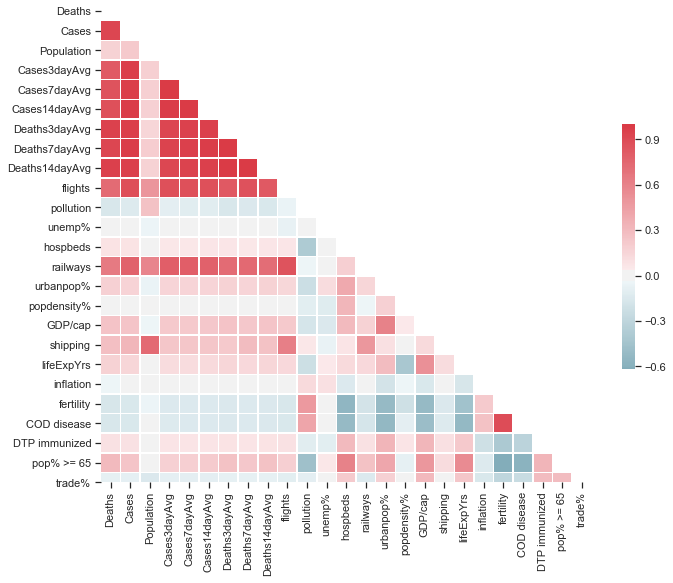

In [982]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [983]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_orig = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
df_sc = pd.DataFrame(scaler.fit_transform(df_orig), index=df_orig.index, columns=df_orig.columns)

display('original',df_orig.head(2),'scaled',df_sc.head(2))

'original'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,46583,839675,322941311,26955.333333,29046.428571,29358.642857,1974.000000,2606.428571,2277.071429,9879630.0,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
Spain,21717,208389,46484062,3238.333333,4392.142857,4297.785714,421.333333,429.857143,494.642857,641020.0,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67


'scaled'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,9.099235,11.361759,1.808514,11.847518,11.803863,11.763837,10.896768,11.389678,10.811846,10.887423,...,-0.182751,1.817933,2.666785,0.604205,-0.185228,-0.684554,-0.768743,0.403393,1.069015,-1.120966
Spain,4.124041,2.657007,0.022818,1.245254,1.611094,1.548686,2.163220,1.719218,2.191580,0.468367,...,-0.147538,0.800831,0.675130,1.034108,-0.257522,-1.009038,-0.773544,0.347512,1.609580,-0.263337


# Misc Clustering Techniques

## - Basic Template for KMeans

In [984]:
from sklearn.model_selection import train_test_split

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


'kmeans info - inertia: 2207.553051117862, iters: 12'

'labels: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1\n 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1\n 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0\n 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0\n 1 0 1 1 0 0 0 1 1 0 1 1]'

'train'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,2,9.099235,11.361759,1.817933,2.666785,0.604205,-0.185228,-0.684554,-0.768743,0.403393,1.069015,-1.120966
Spain,0,4.124041,2.657007,0.800831,0.675130,1.034108,-0.257522,-1.009038,-0.773544,0.347512,1.609580,-0.263337
Italy,0,4.797911,2.366585,0.894039,0.322320,1.000003,-0.263383,-1.001312,-0.783146,0.459275,2.119860,-0.302548
France,0,4.055213,1.950132,1.048812,0.100420,0.962308,-0.230819,-0.553216,-0.730335,0.515156,1.708002,-0.444374
Germany,0,0.835122,1.860821,1.389569,0.803019,0.824093,-0.208675,-0.815893,-0.787948,0.347512,1.924530,0.305079
United States,2,9.099235,11.361759,1.817933,2.666785,0.604205,-0.185228,-0.684554,-0.768743,0.403393,1.069015,-1.120966
Spain,0,4.124041,2.657007,0.800831,0.675130,1.034108,-0.257522,-1.009038,-0.773544,0.347512,1.609580,-0.263337
Italy,0,4.797911,2.366585,0.894039,0.322320,1.000003,-0.263383,-1.001312,-0.783146,0.459275,2.119860,-0.302548
China,0,0.706471,0.939997,-0.145745,11.756538,0.439064,-0.114237,-0.715458,-0.835958,0.682800,0.328578,-0.755556


,Cases
cluster,
0,102
1,57
2,1


## - Basic Template for DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [985]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


"model: DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=2, n_jobs=None, p=None)"

'core_sample_indices_[0:10]: [ 1  2  3  5 10 12 13 14 16 17]'

'components_[0]: [ 4.1240405   2.65700744  0.02281781  1.24525399  1.6110935   1.54868567\n  2.16321964  1.71921835  2.19158013  0.46836705 -0.89327304  1.37673098\n  0.04565608  0.60558296  0.86951124 -0.14753838  0.80083064  0.67512982\n  1.03410849 -0.25752164 -1.00903819 -0.77354433  0.34751198  1.60957959\n -0.26333723]'

'labels/fit_predict[0:10]: [-1  0  0  0 -1  0 -1 -1 -1 -1]'

'train2'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,-1,9.099235,11.361759,1.817933,2.666785,0.604205,-0.185228,-0.684554,-0.768743,0.403393,1.069015,-1.120966
Spain,0,4.124041,2.657007,0.800831,0.675130,1.034108,-0.257522,-1.009038,-0.773544,0.347512,1.609580,-0.263337
Italy,0,4.797911,2.366585,0.894039,0.322320,1.000003,-0.263383,-1.001312,-0.783146,0.459275,2.119860,-0.302548
France,0,4.055213,1.950132,1.048812,0.100420,0.962308,-0.230819,-0.553216,-0.730335,0.515156,1.708002,-0.444374
Germany,-1,0.835122,1.860821,1.389569,0.803019,0.824093,-0.208675,-0.815893,-0.787948,0.347512,1.924530,0.305079
United States,-1,9.099235,11.361759,1.817933,2.666785,0.604205,-0.185228,-0.684554,-0.768743,0.403393,1.069015,-1.120966
Spain,0,4.124041,2.657007,0.800831,0.675130,1.034108,-0.257522,-1.009038,-0.773544,0.347512,1.609580,-0.263337
Italy,0,4.797911,2.366585,0.894039,0.322320,1.000003,-0.263383,-1.001312,-0.783146,0.459275,2.119860,-0.302548
China,-1,0.706471,0.939997,-0.145745,11.756538,0.439064,-0.114237,-0.715458,-0.835958,0.682800,0.328578,-0.755556


,Count
cluster,
-1,15
0,4
1,139
2,2


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

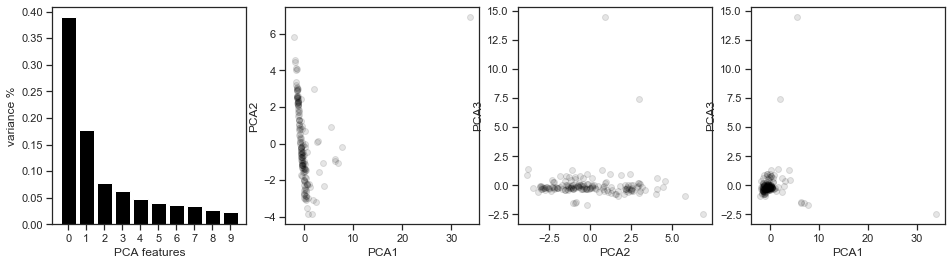

In [986]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



## KMeans on PCA data

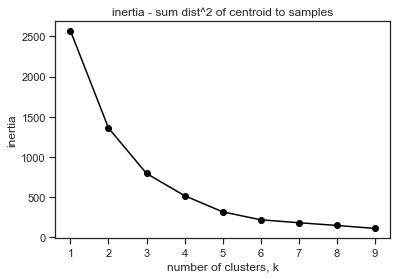

In [987]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

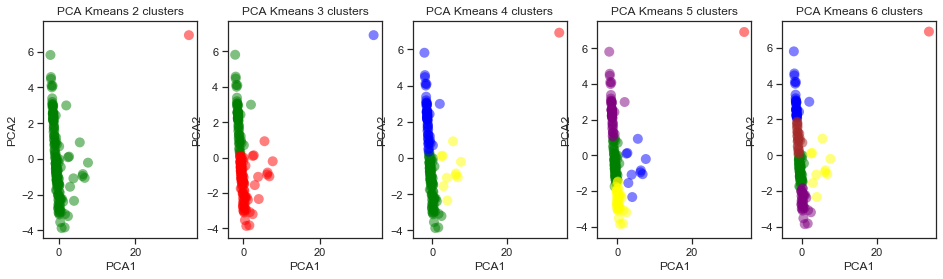

In [988]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
        m = model.fit(df_comp2.iloc[:,:dims])
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

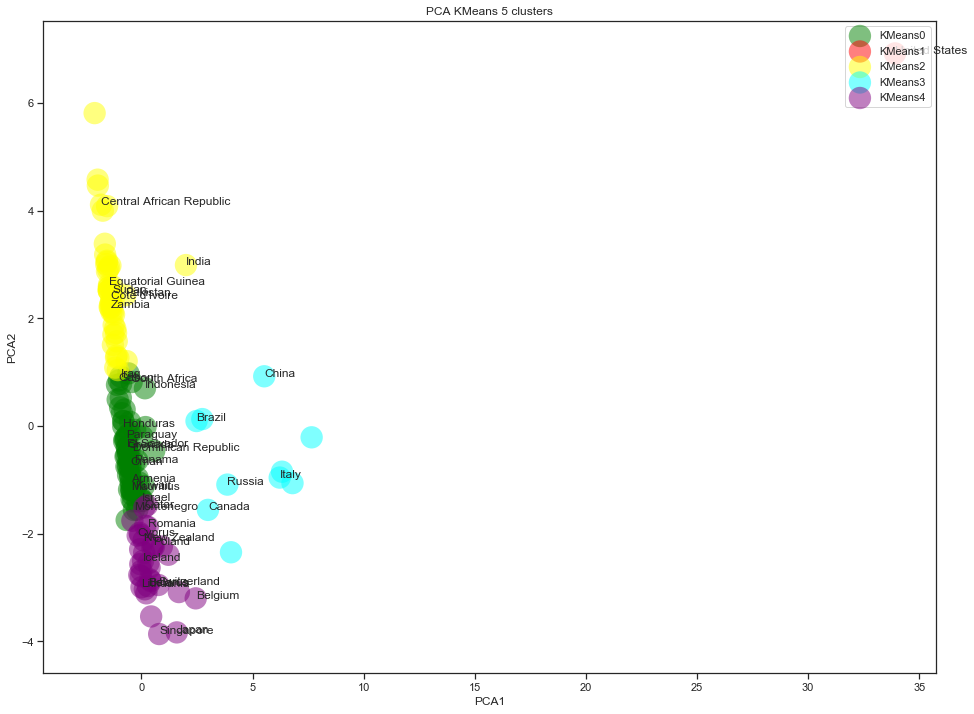

In [1020]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2.iloc[:,:dims])  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(tsne_comps):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['China','Canada','Japan','United States','Singapore','South Africa','Belarus','Brazil','Russia','Italy','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(countries).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=1)
    plt.show()
    
# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','PCA',model, PCA_components)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

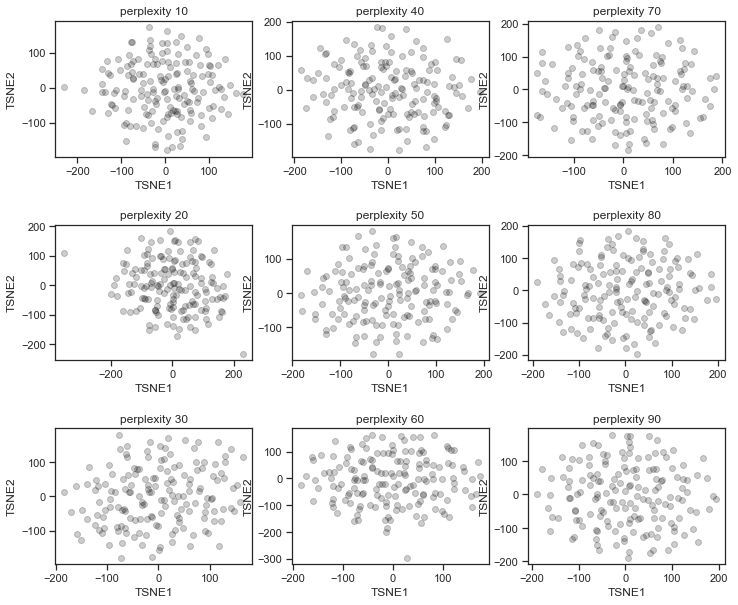

In [990]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=3, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [991]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne_comps = 2
tsne_perp = 30
tsne = TSNE(n_components=tsne_comps, perplexity=tsne_perp)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,-11.898482,4.998778
Spain,-12.065007,4.002456
Italy,-12.068163,4.000498
France,-12.037998,4.059627
Germany,-9.409373,3.425781


## KMeans w/ TSNE

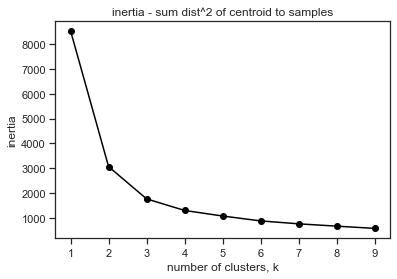

In [992]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

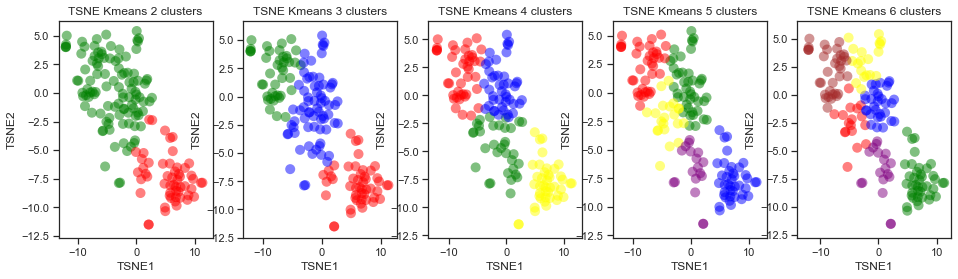

In [993]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

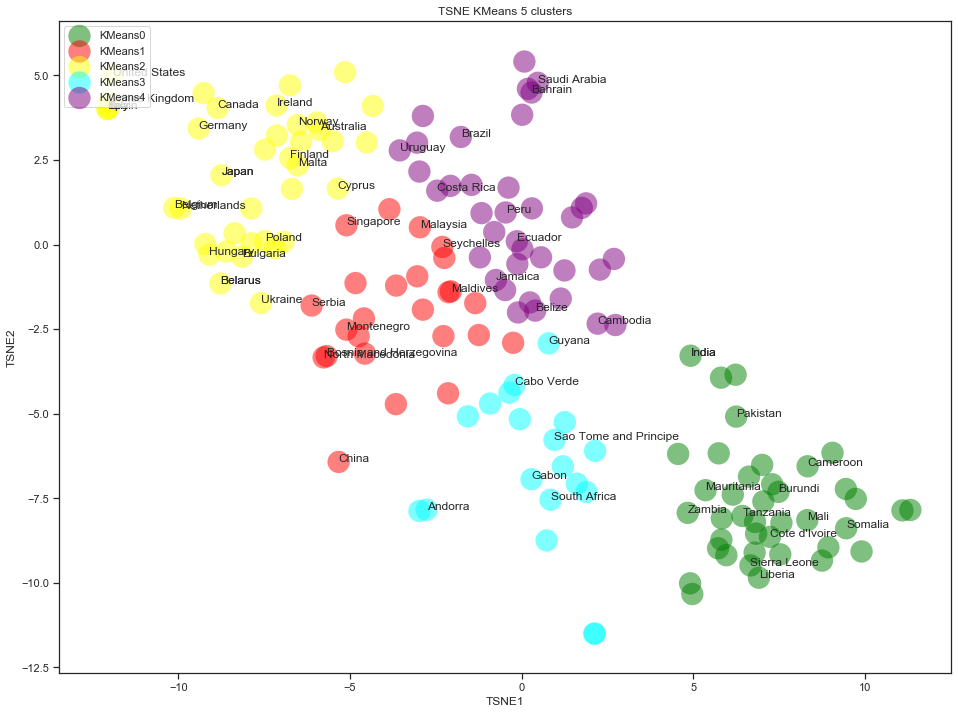

In [994]:
# try 6 clusters -- why i dunno, looks good... 
clusters = 5
model = KMeans(n_clusters=clusters)            

plot_big('KMeans','TSNE',model, TSNE_components, countries=50)

---
## DBScan on PCA Cluster Analysis


"model: DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=1, n_jobs=None, p=None)"

'distinct labels: ct: 33 - {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32} '

'labels/fit_predict[0:10]: [ 0  1  1  1  2  3  4  5  6  7  8  9  8 10 10 11 10 10 10 10 10 12 13 10\n 10 10 14 10 10 10 15 10 10 10 10 16 10 10 17 10 10 10 10 10 10 10 10 18\n 10 10 10 10 10 10 12 10 10 12 10 10 10 10 12 10 10 10 10 10 10 10 10 10\n 10 10 10 10 10 10 10 10 10 10 10 19 10 10 20 10 10 10 10 21 10 22 23 10\n 10 10 10 10 10 10 10 10 10 24 10 25 10 10 10 26 10 10 27 10 10 10 10 28\n 10 10 29 21 10 10 10 10 10 30 10 10 10 10 10 10 10 31 10 10 10 10 10 10\n 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 32]'

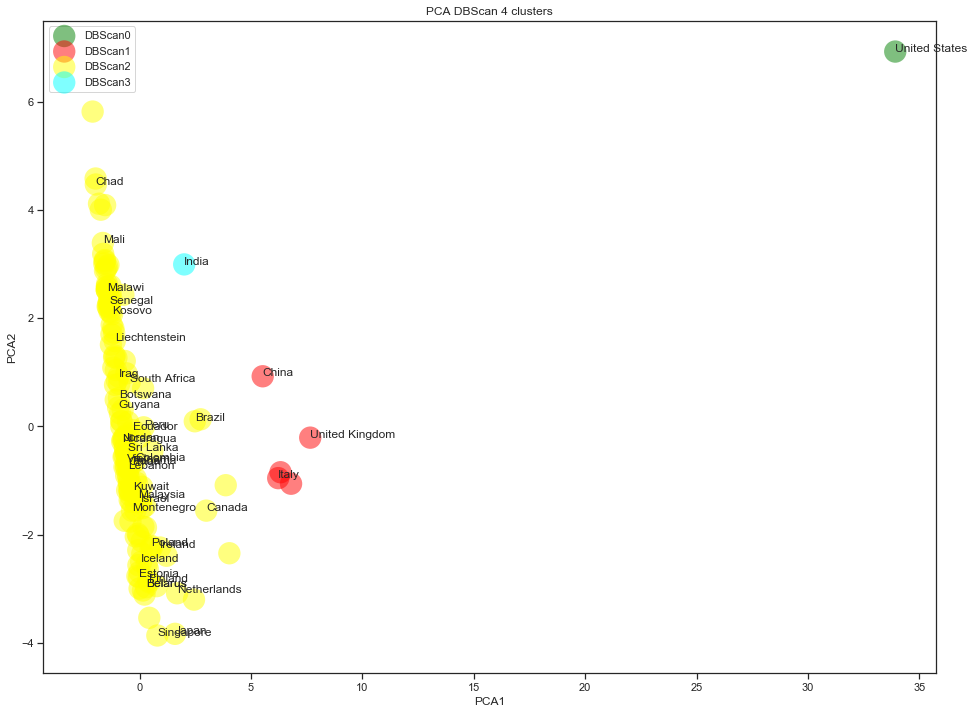

In [995]:

from sklearn.cluster import DBSCAN
import numpy as np

PCA_components3 = PCA_components.copy()
clustering = DBSCAN(eps=2, min_samples=1).fit(PCA_components3)
components = clustering.components_
labels = clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
display(f'distinct labels: ct: {len(set(labels))} - {set(labels)} ')
#display(f'core_sample_indices_[0:10]: {core_sample_indices}')
#display(f'components_[0]: {components}')    
display(f'labels/fit_predict[0:10]: {labels}')                       
#display('PCA_components3',PCA_components3)
    
plot_big('DBScan','PCA',clustering, PCA_components3)


## DBScan on TSNE Cluster Analysis

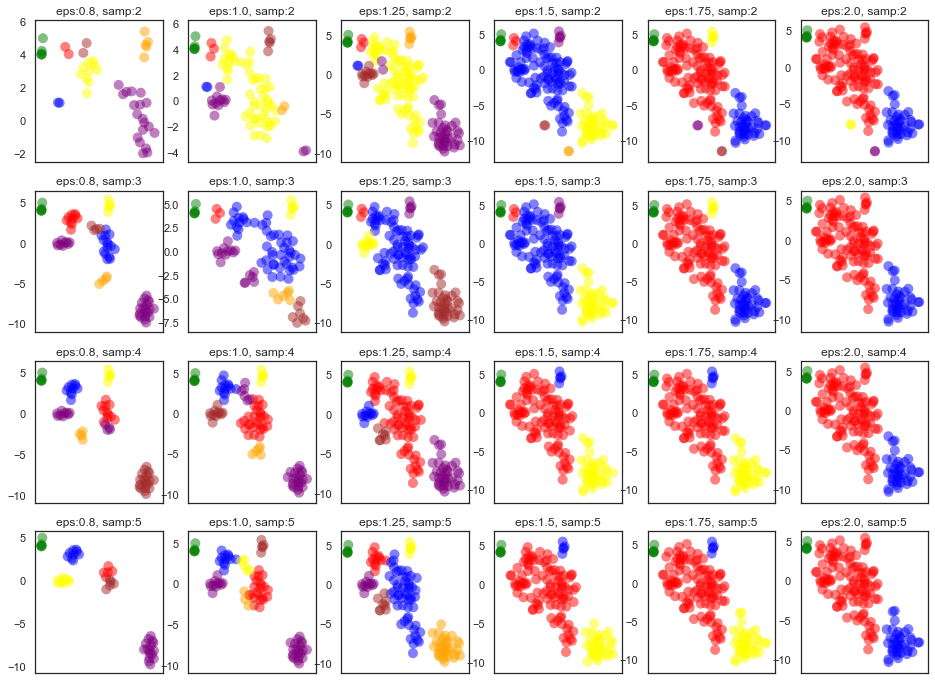

In [996]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product

# try a variety of eps & samples 
samp_list = [2,3,4,5]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75, 2.0]

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

rl = len(samp_list)

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rl][math.floor(k/rl)].tick_params(
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        labelbottom=False) # labels along the bottom edge are off

    TSNE_components3 = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_components3)
    TSNE_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))): 
        tup = []
        for j in range(2):  ## should be cluster dims? pca dims?
            tup.append(TSNE_components3[TSNE_components3['cluster']==i][j])
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rl][math.floor(k/rl)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rl][math.floor(k/rl)].set_title(f'eps:{eps}, samp:{samp}')


"model: DBSCAN(algorithm='auto', eps=1.25, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=4, n_jobs=None, p=None)"

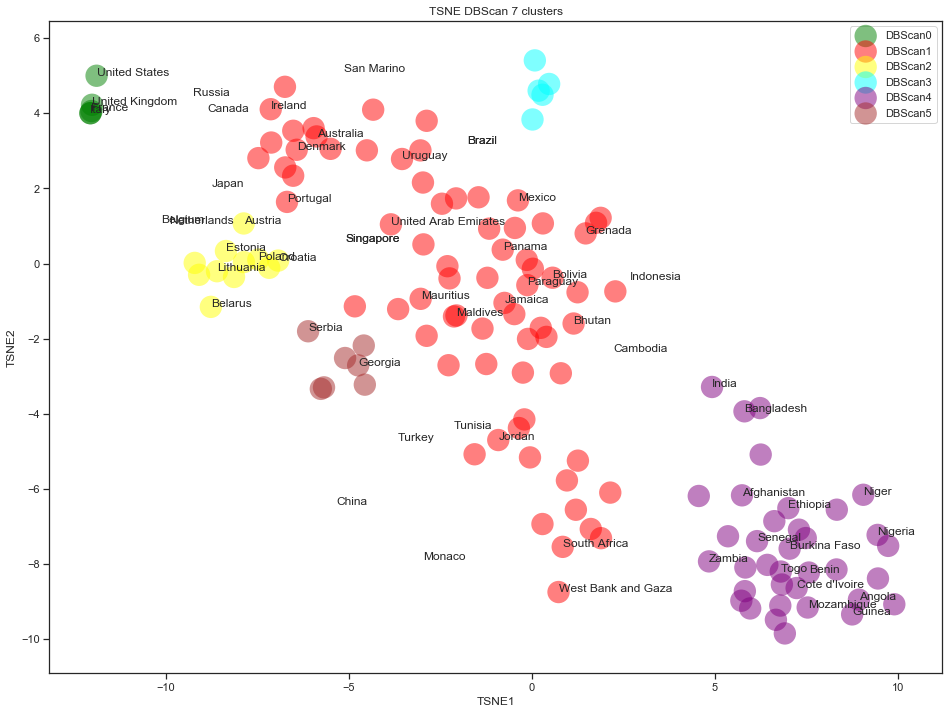

In [1021]:

TSNE_components3 = TSNE_components.copy()
clustering = DBSCAN(eps=1.25, min_samples=4).fit(TSNE_components3)
components = clustering.components_
labels = clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
plot_big('DBScan','TSNE',clustering, TSNE_components3, countries=50)

In [998]:
df_gmerged3.head()

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,46583,839675,USA,322941311,26955.333333,29046.428571,29358.642857,1974.000000,2606.428571,...,35.77,62794.59,54688353.0,78.54,1.81,1.73,5.2,94.0,15.81,20.83
2,Spain,21717,208389,ESP,46484062,3238.333333,4392.142857,4297.785714,421.333333,429.857143,...,93.53,39715.44,17189759.0,83.33,0.70,1.31,5.1,93.0,19.38,51.67
1,Italy,25085,187327,ITA,60627498,2785.000000,3167.428571,3421.785714,475.000000,491.428571,...,205.45,41830.43,10547112.0,82.95,0.61,1.32,4.9,95.0,22.75,50.26
3,France,21373,157125,FRA,66721256,1009.333333,3220.428571,5290.571429,543.000000,597.857143,...,122.34,45342.40,6369200.0,82.53,1.11,1.90,6.0,96.0,20.03,45.16
6,Germany,5279,150648,DEU,82348669,1821.333333,2270.714286,2668.000000,231.000000,210.714286,...,237.37,53074.54,19597633.0,80.99,1.45,1.56,4.8,93.0,21.46,72.11


In [999]:
dfc_g['Russia']
df_gmerged3[df_gmerged3['Country/Region'] == 'Russia']

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
22,Russia,513,57999,RUS,144342396,5048.666667,4787.0,3523.357143,50.666667,45.0,...,8.82,27588.13,6335300.0,72.66,4.47,1.57,4.8,97.0,14.67,41.81


In [1015]:
import plotly.graph_objects as go
import pandas as pd

df = df_gmerged3.copy()

fig = go.Figure(data=go.Choropleth(
    locations = df['Country Code'],
    z = df['Cases'].apply(np.log),
    text = df['Country/Region'],
    colorscale = 'Reds',
    autocolorscale=False,
    colorbar=dict(
            title="Cases",
            titleside="top",
            tickmode="array",
            tickvals=[2, 4 ,7, 9, 11, 13],
            ticktext=["10", "100", "500", "1k",  "50k", "300k+"],
            ticks="outside"
        )))

fig.update_layout(
    title_text='Global COVID Cases',
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular' ),
    annotations = [dict(
        x=0.55, y=0.1,
        xref='paper', yref='paper',
        text='Source: <a href="https://github.com/dougfoo/machineLearning/covid"> John Hopkins + WorldBank</a>',
        showarrow = False
    )]
)

fig.show()
